**Biblioteki**

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

**Parametry**

In [209]:
random_seed = 1
test_size = 0.3

**Opis zbioru danych**

******
1.   **BONUS** - klasa bonus malus (zakres 1-13, 1 max zwyżka, 3 podstawowa, 13 max zniżka).
2.   **WOJ** - województwo.
3.   **KL_SUB** - klasa sumy ubezpieczenia.
4.   **KL_WIEK** - klasa wieku klienta.
5.   **ZN_ROK** - procent zniżki za jednorazową opłatę składki (0 gdy płatna w ratach).
6.   **ZN_OC** - procent zniżki za OC w PZU (0 gdy brak OC).
7.   **PROC_SKL** - procent składki wg taryfy.
8.   **SUMA_UB** - suma ubezpieczenia (wartość pojazdu).
9.   **KWOTA** - kwota wypłaty związana z oszustwem.
10.  **PLEC** - Plec (M , K).
11.  **EXPO** - ryzyko przeszacowane (ekspozycja) (= długość polisy w roku 2015 * suma ubezp.).
12.  **R_PROD** - Rok produkcji pojazdu.
13.  **R_URO** - rok urodzenia posiadacza.
14.  **WIEK_POJ** - wiek pojazdu (w latach w roku 2015)
15.  **WIEK_POS** - wiek posiadacza (w roku 2015)
16.  **FRAUD** - *oszustwo (FRAUD=1) zawiera fraud techniczny. To jest nasz target.*
17.  **TECH** - flaga technicznej definicji fraudu (TECH=1) 

# 1. **Przegląd zbioru danych**

1. **Ogólny przegląd zmiennych**

In [210]:
df.head()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,SUMA_UB,KWOTA,POJEM,PLEC,EXPO,R_PROD,R_URO,WIEK_POJ,WIEK_POS,FRAUD,TECH
0,13,3,2,3,5,15,12.12,1800.0,0.0,1400.0,M,1301.917808,2014.0,1967.0,5.0,52.0,0,0
1,5,3,2,3,0,15,12.12,1900.0,0.0,1997.0,M,1426.301370,2006.0,1972.0,13.0,47.0,0,0
2,13,3,3,4,5,15,12.12,3300.0,0.0,1389.0,M,2911.232877,2017.0,1964.0,2.0,55.0,1,1
3,13,3,2,4,0,15,12.12,1600.0,0.0,1100.0,M,1122.191781,2016.0,1958.0,3.0,61.0,0,0
4,13,3,2,3,5,15,12.12,1010.0,0.0,1500.0,M,794.164384,2014.0,1971.0,5.0,48.0,0,0


In [211]:
df.describe()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,SUMA_UB,KWOTA,POJEM,EXPO,R_PROD,R_URO,WIEK_POJ,WIEK_POS,FRAUD,TECH
count,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8914.000000,8811.000000,8914.000000,8877.000000,8895.000000,8877.000000,8895.000000,8914.000000,8914.000000
mean,8.813664,21.271932,1.834081,3.087839,3.508526,15.324770,10.012078,1710.772940,101.387618,1261.579276,964.768564,2013.699448,1971.706914,5.300552,47.293086,0.212923,0.198676
std,3.876784,13.021437,0.692607,0.847394,13.049096,38.608023,27.482417,2279.575572,1282.638912,473.041481,1836.529274,3.976045,12.306651,3.976045,12.306651,0.409397,0.399026
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.600000,25.000000,0.000000,80.000000,0.356164,1990.000000,1920.000000,0.000000,18.000000,0.000000,0.000000
25%,5.000000,14.000000,1.000000,3.000000,0.000000,15.000000,8.900000,800.000000,0.000000,796.000000,268.232877,2011.000000,1964.000000,2.000000,39.000000,0.000000,0.000000
50%,10.000000,16.000000,2.000000,3.000000,5.000000,15.000000,8.900000,1400.000000,0.000000,1332.000000,670.684932,2015.000000,1972.000000,4.000000,47.000000,0.000000,0.000000
75%,13.000000,32.000000,2.000000,4.000000,5.000000,15.000000,10.100000,2300.000000,0.000000,1593.000000,1323.287671,2017.000000,1980.000000,8.000000,55.000000,0.000000,0.000000
max,13.000000,49.000000,5.000000,5.000000,1215.000000,3645.000000,2595.240000,170100.000000,65000.000000,6823.000000,142604.383560,2019.000000,2001.000000,29.000000,99.000000,1.000000,1.000000


Liczba obiektów typu "null"

In [212]:
df.isnull().sum()

BONUS         0
WOJ           0
KL_SUB        0
KL_WIEK       0
ZN_ROK        0
ZN_OC         0
PROC_SKL      0
SUMA_UB       0
KWOTA         0
POJEM       103
PLEC         87
EXPO          0
R_PROD       37
R_URO        19
WIEK_POJ     37
WIEK_POS     19
FRAUD         0
TECH          0
dtype: int64

Zbior danych zawiera obiekty typu null w ilości 302.

In [213]:
df.isnull().sum().sum()

302

2. **Macierze korelacji**

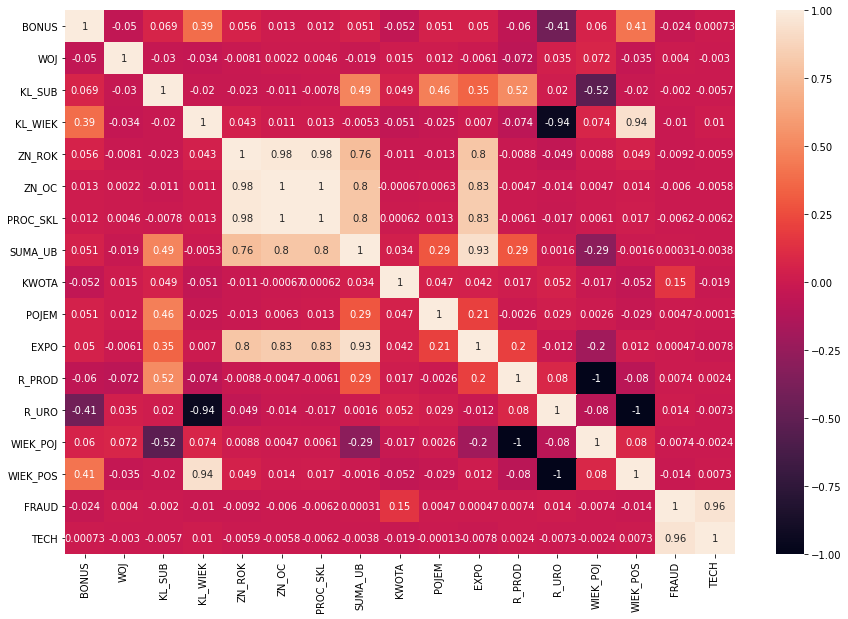

In [214]:
cm = df.corr()

fig = plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True)
plt.show()

# **2. Przygotowanie danych**

1. **Usuwanie obiektów typu null**

Zastąpienie danych kategoryjnych >>> nominalny. Zmienna w "PLEC"

In [215]:
df['PLEC'] = pd.factorize(df['PLEC'])[0]
df.PLEC.value_counts()

 0    6835
 1    1992
-1      87
Name: PLEC, dtype: int64

In [216]:
df.head()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,ZN_OC,PROC_SKL,SUMA_UB,KWOTA,POJEM,PLEC,EXPO,R_PROD,R_URO,WIEK_POJ,WIEK_POS,FRAUD,TECH
0,13,3,2,3,5,15,12.12,1800.0,0.0,1400.0,0,1301.917808,2014.0,1967.0,5.0,52.0,0,0
1,5,3,2,3,0,15,12.12,1900.0,0.0,1997.0,0,1426.301370,2006.0,1972.0,13.0,47.0,0,0
2,13,3,3,4,5,15,12.12,3300.0,0.0,1389.0,0,2911.232877,2017.0,1964.0,2.0,55.0,1,1
3,13,3,2,4,0,15,12.12,1600.0,0.0,1100.0,0,1122.191781,2016.0,1958.0,3.0,61.0,0,0
4,13,3,2,3,5,15,12.12,1010.0,0.0,1500.0,0,794.164384,2014.0,1971.0,5.0,48.0,0,0


2. **Wypełnić brakujące obiekty metodą najbliższego sąsiada**

In [217]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=4, weights="uniform")
imp = imp.fit_transform(df)

df_without_null = pd.DataFrame(imp)
df_without_null.columns = df.columns

Teraz nasz zbiór danych nie zawiera obiekty tupy null.

In [218]:
df_without_null.isnull().sum().sum()

0

3. **Usunięcie zmiennych o wysokiej korelacji**


Nasze przypadki są to zmienne 'ZN_OC', 'PROC_SKL', 'EXPO', 'WIEK_POS'. 

Usuwamy również 'TECH' ponieważ został on wzięty pod uwagę w 'FRAUD'.

In [219]:
df_wn = df_without_null.drop(['ZN_OC', 'PROC_SKL', 'EXPO', 'WIEK_POS', 'TECH'], axis=1) 
df_wn.head()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,SUMA_UB,KWOTA,POJEM,PLEC,R_PROD,R_URO,WIEK_POJ,FRAUD
0,13.0,3.0,2.0,3.0,5.0,1800.0,0.0,1400.0,0.0,2014.0,1967.0,5.0,0.0
1,5.0,3.0,2.0,3.0,0.0,1900.0,0.0,1997.0,0.0,2006.0,1972.0,13.0,0.0
2,13.0,3.0,3.0,4.0,5.0,3300.0,0.0,1389.0,0.0,2017.0,1964.0,2.0,1.0
3,13.0,3.0,2.0,4.0,0.0,1600.0,0.0,1100.0,0.0,2016.0,1958.0,3.0,0.0
4,13.0,3.0,2.0,3.0,5.0,1010.0,0.0,1500.0,0.0,2014.0,1971.0,5.0,0.0


4. **Skalowanie danych**

In [220]:
X = df_wn.drop(['FRAUD'], axis=1)
y = df_wn.FRAUD

In [221]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(X))
scaled_data.columns = X.columns
X = scaled_data
X.head()

,BONUS,WOJ,KL_SUB,KL_WIEK,ZN_ROK,SUMA_UB,KWOTA,POJEM,PLEC,R_PROD,R_URO,WIEK_POJ
0,1.079908,-1.403298,0.239570,-0.103664,0.114304,0.039144,-0.079051,0.294499,-0.493464,0.076283,-0.382784,-0.076283
1,-0.983774,-1.403298,0.239570,-0.103664,-0.268886,0.083014,-0.079051,1.561154,-0.493464,-1.937548,0.023868,1.937548
2,1.079908,-1.403298,1.683471,1.076490,0.114304,0.697198,-0.079051,0.271160,-0.493464,0.831469,-0.626776,-0.831469
3,1.079908,-1.403298,0.239570,1.076490,-0.268886,-0.048596,-0.079051,-0.342012,-0.493464,0.579740,-1.114759,-0.579740
4,1.079908,-1.403298,0.239570,-0.103664,0.114304,-0.307431,-0.079051,0.506669,-0.493464,0.076283,-0.057462,-0.076283


Pierwszy zbiór danych

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

Drugi zbiór danych. Wyrzucanie zmiennych za pomocą "Feature Importance" 

W punkcie 4 będzie wykres "Feature Importance"

In [223]:
X_n = df_wn.drop(['FRAUD', 'SUMA_UB'], axis=1)
y_n = df_wn.FRAUD

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_n, y_n, test_size=test_size, random_state=random_seed)

# 3. Modele klasyfikacyjne

1. Jako benchmark przydział Latem Dirichlet **LDA(Latent Dirichlet Allocation)**

In [224]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def mod_LDA(X_train, y_train):
  m_LDA = LDA()
  m_LDA.fit(X_train, y_train)
  return m_LDA

2. Sztuczne sieci neuronowe (eng. Artificial Neural Networks)


In [225]:
from keras.models import Sequential
from keras.layers import Dense
def mod_ANN(X_train, y_train):
  m_ANN = Sequential()
  m_ANN.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
  m_ANN.add(Dense(15, activation='relu'))
  m_ANN.add(Dense(1, activation='sigmoid'))

  m_ANN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

  m_ANN.fit(X_train, y_train, epochs=20, batch_size=30)

  return m_ANN

3.   Drzewa decyzyjne **DT (eng. Decision Tree)**

In [226]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def mod_DT(X_train, y_train):
  parameters = {'max_depth' : range(1, 20), 
                'min_samples_split' : [0.1, 0.2, 0.3],
                'criterion' : ["entropy", "gini"]}
                
  m_DT = DecisionTreeClassifier(random_state=random_seed)
  m_DT = GridSearchCV(m_DT, parameters, scoring="roc_auc")
  m_DT.fit(X_train, y_train)

  return m_DT

4. Las losowy **(eng. Random Forest)**

In [227]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
def mod_RF(X_train, y_train):

  parameters = {'max_depth' : range(1, 20)}

  model_randomforest = RandomForestClassifier(random_state = random_seed)

  model_RF = GridSearchCV(model_randomforest, parameters, scoring="roc_auc")
  model_RF.fit(X_train, y_train)
  return model_RF

# 4. Porównanie wybranych modeli


In [ ]:
def run_all_model(X_train, y_train):
  models = list()
  models.append(mod_LDA(X_train, y_train))
  models.append(mod_ANN(X_train, y_train))
  models.append(mod_DT(X_train, y_train))
  models.append(mod_RF(X_train, y_train))
  return models

models_ds_1 = run_all_model(X_train, y_train)
models_ds_2 = run_all_model(X_train_2, y_train_2)

1. Wybieram jeden model do oszacowania wpływu zmiennych

BONUS Score: 0.11
WOJ Score: 0.15
KL_SUB Score: 0.01
KL_WIEK Score: 0.01
ZN_ROK Score: 0.03
SUMA_UB Score: 0.19
KWOTA Score: 0.06
POJEM Score: 0.14
PLEC Score: 0.03
R_PROD Score: 0.06
R_URO Score: 0.16
WIEK_POJ Score: 0.06


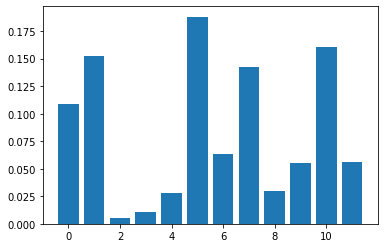

In [233]:
model = DecisionTreeClassifier()
model.fit(X, y)
importance = model.feature_importances_

for i, v in enumerate(importance):
  col = X.columns
  print(f'{col[i]} Score: {v:0.2f}')

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Z tego wynika, że największy wpływ ma zmienna SUMA_UB. Można spróbować go usunąć i zobaczyć wyniki.

SUMA_UB - suma ubezpieczenia (wartość pojazdu).

2. **Krzywa AUC**

Obliczamy krzywą AUC dla naszych modeli.



In [234]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def auc_sc(model, X_test, y_test):
  probs = model.predict(X_test)
  auc = roc_auc_score(y_test, probs)
  fpr, tpr, _ = roc_curve(y_test, probs)
  return fpr, tpr, auc

auc_LDA_1 = auc_sc(models_ds_1[0], X_test, y_test)
auc_ANN_1 = auc_sc(models_ds_1[1], X_test, y_test)
auc_DT_1 = auc_sc(models_ds_1[2], X_test, y_test)
auc_RF_1 = auc_sc(models_ds_1[3], X_test, y_test)

auc_LDA_2 = auc_sc(models_ds_2[0], X_test_2, y_test_2)
auc_ANN_2 = auc_sc(models_ds_2[1], X_test_2, y_test_2)
auc_DT_2 = auc_sc(models_ds_2[2], X_test_2, y_test_2)
auc_RF_2 = auc_sc(models_ds_2[3], X_test_2, y_test_2)



Budujemy dwie krzywe wyników auc dla różnych zbiorów danych

3. **Wykres krzywej AUC**

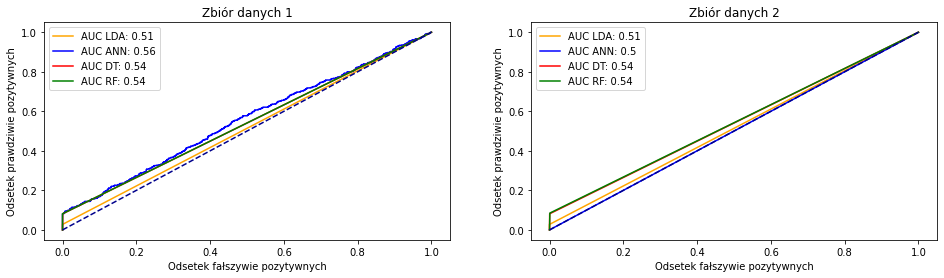

In [235]:
_, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(auc_LDA_1[0], auc_LDA_1[1], color='orange', label=f'AUC LDA: {round(auc_LDA_1[2], 2)}')
ax[0].plot(auc_ANN_1[0], auc_ANN_1[1], color='blue', label=f'AUC ANN: {round(auc_ANN_1[2], 2)}')
ax[0].plot(auc_DT_1[0], auc_DT_1[1], color='red', label=f'AUC DT: {round(auc_DT_1[2], 2)}')
ax[0].plot(auc_RF_1[0], auc_RF_1[1], color='green', label=f'AUC RF: {round(auc_RF_1[2], 2)}')
ax[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax[0].set_title('Zbiór danych 1')
ax[0].set_xlabel('Odsetek fałszywie pozytywnych')
ax[0].set_ylabel('Odsetek prawdziwie pozytywnych')
ax[0].legend()

ax[1].plot(auc_LDA_2[0], auc_LDA_2[1], color='orange', label=f'AUC LDA: {round(auc_LDA_2[2], 2)}')
ax[1].plot(auc_ANN_2[0], auc_ANN_2[1], color='blue', label=f'AUC ANN: {round(auc_ANN_2[2], 2)}')
ax[1].plot(auc_DT_2[0], auc_DT_2[1], color='red', label=f'AUC DT: {round(auc_DT_2[2], 2)}')
ax[1].plot(auc_RF_2[0], auc_RF_2[1], color='green', label=f'AUC RF: {round(auc_RF_2[2], 2)}')
ax[1].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax[1].set_title('Zbiór danych 2')
ax[1].set_xlabel('Odsetek fałszywie pozytywnych')
ax[1].set_ylabel('Odsetek prawdziwie pozytywnych')
ax[1].legend()

plt.show()

# 5. Dyskusja porównawcza

Do oceny jakości klasyfikatora została przyjęta krzywa auc score. Jest to jeden z najbardziej popularnych metryk oceny jakości modeli. 

Teraz możemy potwierdzić, że zmienna 'SUMA_UB' ma duży wpływ na nasze modele. Widać, że w niektórych modelach tracimy przez usunięcie zmiennej. Przykładem może być ANN, gdzie auc 0,6 został utracony.

Mówiąc o ogólnej ocenie modelu, możemy powiedzieć, że sieć neuronowa **(eng. Artificial Neural Networks)** wykazała się najlepszymi wynikami 0.56 AUC.
Sensowne jest kontynuowanie pracy nad wyborem hiperparametrów sieci i być może da to lepsze wyniki. 

Jeśli jednak mówimy o wyniku w praktyce. AUC 0,56 jest bardzo słabym wskaźnikiem, nasz model praktycznie odgaduje właściwy wynik. Gdyby nasz model miał wynik powyżej 0,65, wynik nie byłby już zły. Ale wysoki auc może też powiedzieć, że model został w stanie "overfitting". Wniosek jest taki, że ma to dwa możliwe problemy. Pierwszym z nich jest to, że parametry nie są prawidłowo wybrane, należy określić więcej parametrów i zobaczyć wyniki. Drugi problem polega na tym, że tych danych po prostu nie wystarczy do prawidłowego nauczania modeli. To znaczy, że oryginalne dane nie nadają się pierwotnie do szkolenia modeli.
